In [1]:
# install packages
install.packages('tidyverse')
install.packages('magrittr')
install.packages('lubridate')
install.packages('iNEXT')
install.packages('vegan')
install.packages('networkD3')
install.packages('permute')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘permute’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘htmlwidgets’, ‘igraph’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library('tidyverse')
library('magrittr')
library('lubridate')
library('iNEXT')
library('vegan')
library('networkD3')
library('permute')

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7



In [3]:
# lendo o arquivo de entrada

df <- read_csv("data_pcrs.csv")

df <- df %>% pivot_longer(!`Espécie`, names_to = "Localidade", values_to = "Abundância")

distinct(df, Localidade)

Rows: 25 Columns: 11

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Espécie
dbl (10): Pelotas, Corrientes, Turuçu, RPPN, Lami, Pacheca, Taim, Itapuã, It...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Localidade
<chr>
Pelotas
Corrientes
Turuçu
RPPN
Lami
Pacheca
Taim
Itapuã
Itapeva


In [4]:
# Sankey

nodes <- data.frame(name = c(as.character(df$Espécie), as.character(df$Localidade)) %>% unique())


df$IDsource <- match(df$Espécie, nodes$name) - 1
df$IDtarget <- match(df$Localidade, nodes$name) - 1

ColourScal <- 'd3.scaleOrdinal() .range(["#FDE725FF","#B4DE2CFF","#6DCD59FF","#35B779FF",
"#1F9E89FF","#26828EFF","#31688EFF","#3E4A89FF","#482878FF","#440154FF"])'

sankeyNetwork(
  Links = df, Nodes = nodes,
  Source = "IDsource", Target = "IDtarget",
  Value = "Abundância", NodeID = "name",
  sinksRight = FALSE, colourScale = ColourScal, nodeWidth = 40, fontSize = 13, nodePadding = 20
)

Links is a tbl_df. Converting to a plain data frame.



HTML widgets cannot be represented in plain text (need html)

In [5]:
# top 5 specie

top_specie <- df %>% arrange(-Abundância) %>% slice(1:5) 

Run 0 stress 0.0001982578 
Run 1 stress 0.0001433684 
... New best solution
... Procrustes: rmse 0.01763102  max resid 0.2522905 
Run 2 stress 0.0001445919 
... Procrustes: rmse 0.01645019  max resid 0.2189628 
Run 3 stress 0.0003010406 
... Procrustes: rmse 0.01737879  max resid 0.2306621 
Run 4 stress 0.0001693543 
... Procrustes: rmse 0.01714977  max resid 0.2278177 
Run 5 stress 0.0001349035 
... New best solution
... Procrustes: rmse 0.005650974  max resid 0.07877107 
Run 6 stress 0.0001384938 
... Procrustes: rmse 0.01418731  max resid 0.2118662 
Run 7 stress 0.0001576077 
... Procrustes: rmse 0.01681692  max resid 0.2212701 
Run 8 stress 0.0001511839 
... Procrustes: rmse 0.01484411  max resid 0.2222323 
Run 9 stress 0.0001561844 
... Procrustes: rmse 0.01578248  max resid 0.2078733 
Run 10 stress 0.0001943058 
... Procrustes: rmse 0.01092012  max resid 0.1453463 
Run 11 stress 0.0006672049 
Run 12 stress 0.0001327549 
... New best solution
... Procrustes: rmse 0.002272715  max 

Warning message in metaMDS(dist_bray):
“stress is (nearly) zero: you may have insufficient data”
Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”
Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”
Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”
Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”
Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”
Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”
Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”


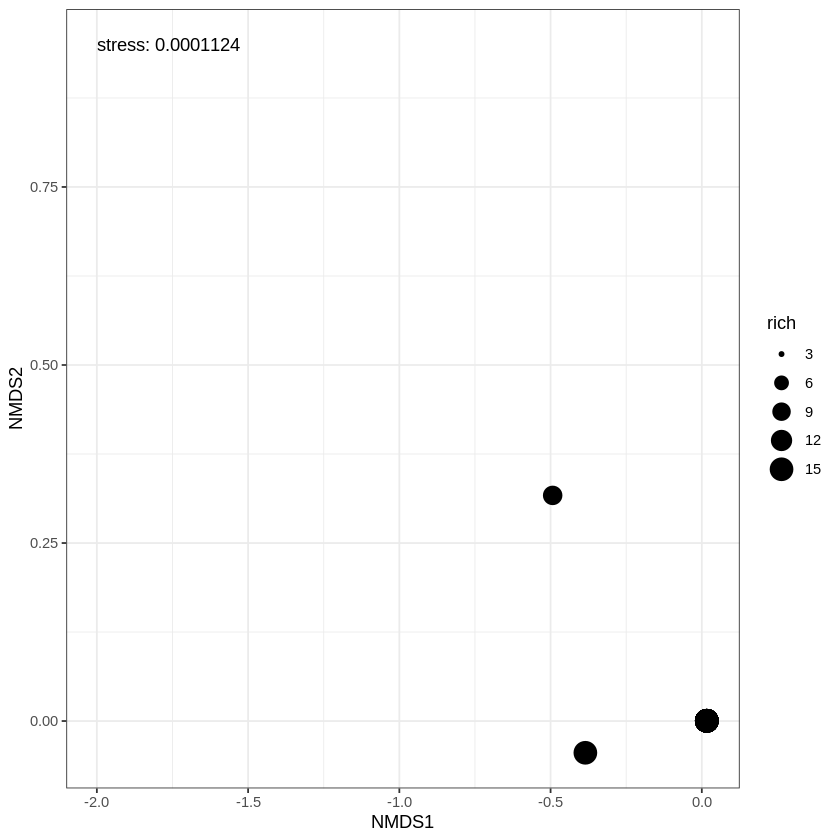

In [6]:
# NMDS

rich <- df  %>%  group_by(Localidade) %>% 
  filter(Abundância > 0) %>%
  summarise(rich = n_distinct(Espécie))

data_nmds <- df %>%
  group_by(Espécie, Localidade) %>%
  pivot_wider(names_from = Espécie, values_from = Abundância) %>%
  mutate(
    across(everything(), ~ replace_na(.x, 0))
  ) %>% left_join(rich, by = "Localidade")


run_nmds <- data_nmds

run_nmds$Localidade <- NULL
run_nmds$rich <- NULL

dist_bray <- vegdist(run_nmds, method = "bray", binary = TRUE)

nmds <- metaMDS(dist_bray)

scores(nmds)  %>%
  as_tibble() %>%
  cbind(data_nmds) %>%
  as_tibble()%>%
  ggplot(aes(x = NMDS1, y = NMDS2)) +
  geom_point(aes(size = rich)) +
  stat_ellipse(geom = "polygon", aes(group = rich), alpha = 0.3) +
  annotate("text", x = -2, y = 0.95, label = paste0("stress: ", format(nmds$stress, digits = 4)), hjust = 0) +
  theme_bw()


In [7]:
# Permanova

adonis(dist_bray~data_nmds$Localidade, permutations = 1000)


Call:
adonis(formula = dist_bray ~ data_nmds$Localidade, permutations = 1000) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

                      Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)
data_nmds$Localidade   9    0.0328 0.0036435 0.18912 0.00704      1
Residuals            240    4.6238 0.0192657         0.99296       
Total                249    4.6566                   1.00000       

`geom_smooth()` using formula 'y ~ x'



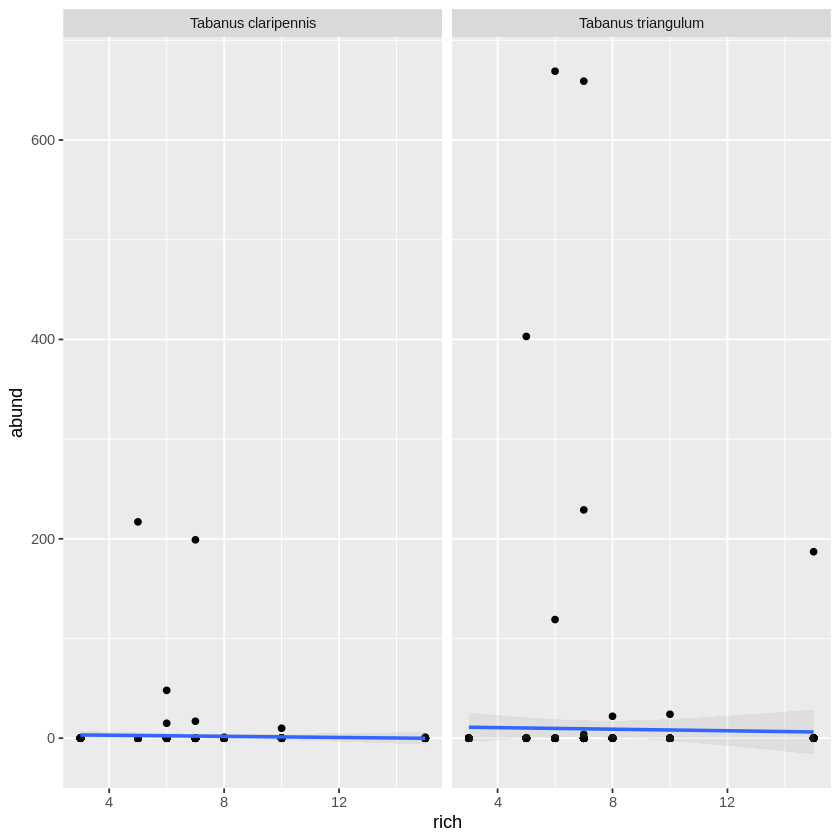

In [8]:
# Rich x Abund

rich_abund <- data_nmds %>% 
  pivot_longer(!c(Localidade, rich), names_to = "Espécie", values_to = "abund") %>% 
  filter(Espécie %in% top_specie$Espécie)

ggplot(rich_abund, aes(x = rich, y = abund)) +
  geom_point() +
  geom_smooth(method = "lm", alpha = .15) +
  facet_wrap(~Espécie)


In [9]:
# Diversidade

abund <- read_csv("data_pcrs.csv")  %>%
    column_to_rownames(var = "Espécie")

resultados_tabanidae <- iNEXT(abund,
                              q = c(0, 1, 2),
                              datatype = "abundance",
                              endpoint = 400
)

Rows: 25 Columns: 11

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Espécie
dbl (10): Pelotas, Corrientes, Turuçu, RPPN, Lami, Pacheca, Taim, Itapuã, It...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



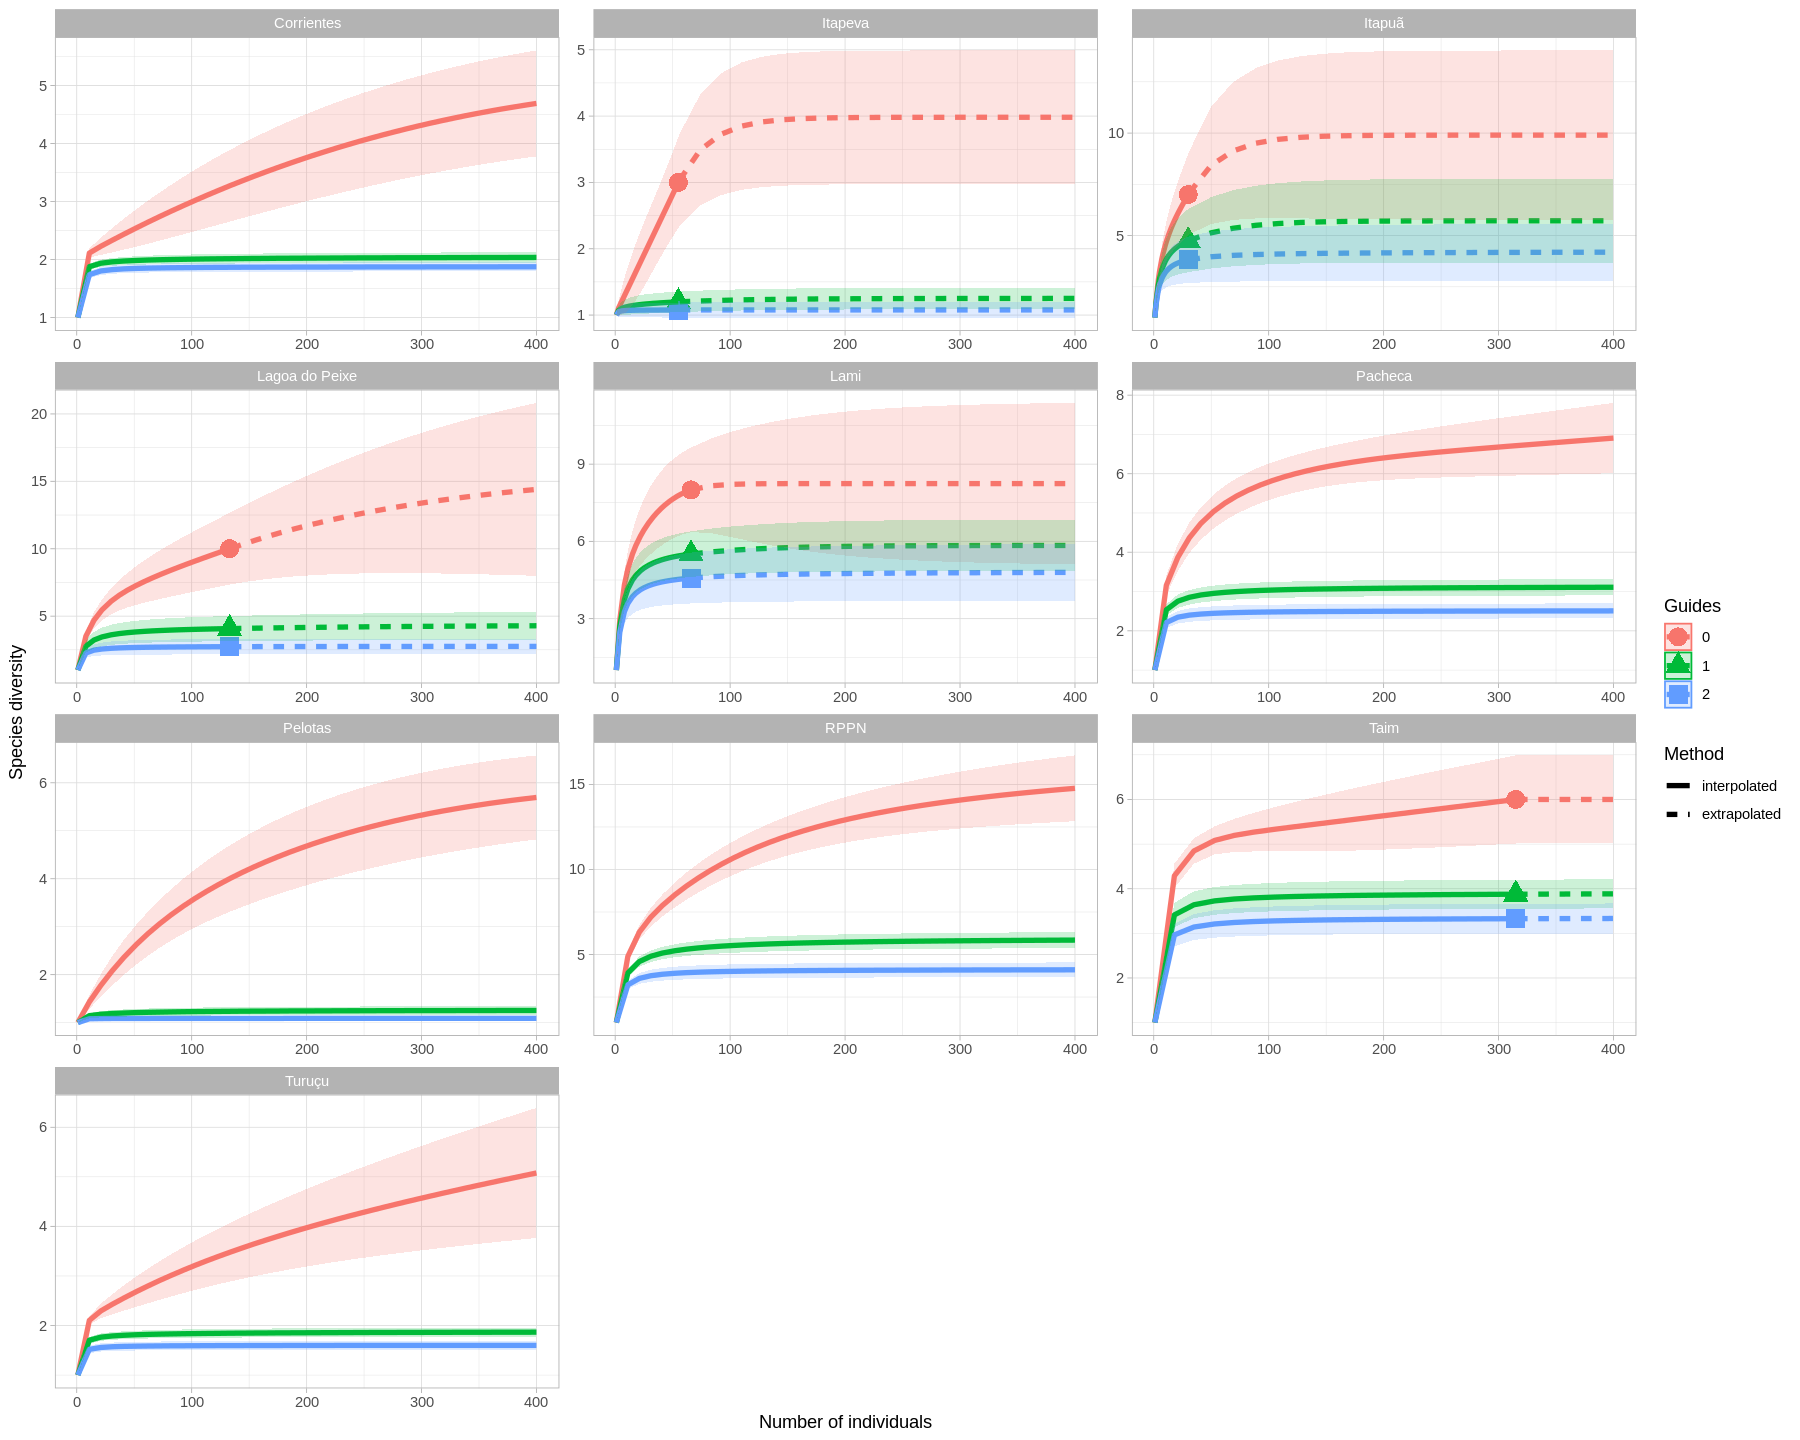

In [10]:
# Resultado 0 = Species richness; 1 = Shannon diversity; 2 = Simpson diversity

options(repr.plot.width=15, repr.plot.height=12)

ggiNEXT(resultados_tabanidae, type = 1, facet.var = 'site') + theme_light() + 
  facet_wrap(~site, ncol=3, scales = 'free') 
